In [211]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import itertools
import time
import torch
import pylab as plt
# %matplotlib inline
# %matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import memory as mem   
from feedforward import Feedforward

## Helper Functions

In [212]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [213]:
class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env: gym.Env, bins = 5):
        """A wrapper for converting a 1D continuous actions into discrete ones.
        Args:
            env: The environment to apply the wrapper
            bins: number of discrete actions
        """
        assert isinstance(env.action_space, spaces.Box)
        super().__init__(env)
        self.bins = bins
        self.orig_action_space = env.action_space
        self.action_space = spaces.Discrete(self.bins)

    def action(self, action):
        """ discrete actions from low to high in 'bins'
        Args:
            action: The discrete action
        Returns:
            continuous action
        """
        return self.orig_action_space.low + action/(self.bins-1.0)*(self.orig_action_space.high-self.orig_action_space.low)  

# DQN

Complete the implemenation of DQN with a main Q-network and a target Q-network

In [214]:
""" Q Network, input: observations, output: q-values for all actions """
class QFunction(Feedforward):
    def __init__(self, observation_dim, action_dim, 
                 hidden_sizes=[100,100], learning_rate = 0.0002):
        super().__init__(input_size=observation_dim, 
                         hidden_sizes=hidden_sizes, 
                         output_size=action_dim)
        self.optimizer=torch.optim.Adam(self.parameters(), 
                                        lr=learning_rate, 
                                        eps=0.000001)
        # The L1 loss is often easier for choosing learning rates etc than for L2 (MSELoss)
        #  Imagine larger q-values (in the hundreds) then an squared error can quickly be 10000!, 
        #  whereas the L1 (absolute) error is simply in the order of 100. 
        self.loss = torch.nn.SmoothL1Loss()
        
    def fit(self, observations, actions, targets):
        # TODO: complete this
        self.optimizer.zero_grad()

        #calculate q(s,a) values for the actions chosen

        q_sa = self.Q_value(observations, actions)     # (B,)
        loss = self.loss(q_sa, targets)

        loss.backward()
        self.optimizer.step()
        return loss.item()
        
       
    def Q_value(self, observations, actions):
        # compute the Q value for the give actions
        # Hint: use the torch.gather function select the right outputs 
        # Complete this
        #gather q(s,a) for chosen actions
        q = self.forward(observations)                 # (B,n_actions)
        actions = actions.unsqueeze(1)        # (B,1)
        return q.gather(1, actions).squeeze(1)
    
    def maxQ(self, observations):
        # compute the maximal Q-value
        # Complete this
        q = self.forward(observations)
        return q.max(dim=1)[0]

    
    def greedyAction(self, observations):
        # this computes the greedy action
        return np.argmax(self.predict(observations), axis=-1)

In [215]:
class DQNAgent(object):
    """
    Agent implementing Q-learning with NN function approximation.    
    """
    def __init__(self, observation_space, action_space, **userconfig):
        
        if not isinstance(observation_space, spaces.box.Box):
            raise UnsupportedSpace('Observation space {} incompatible ' \
                                   'with {}. (Require: Box)'.format(observation_space, self))
        if not isinstance(action_space, spaces.discrete.Discrete):
            raise UnsupportedSpace('Action space {} incompatible with {}.' \
                                   ' (Reqire Discrete.)'.format(action_space, self))
        
        self._observation_space = observation_space
        self._action_space = action_space
        self._action_n = action_space.n
        self._config = {
            "eps": 0.05,            # Epsilon in epsilon greedy policies                        
            "discount": 0.95,
            "buffer_size": int(1e5),
            "batch_size": 128,
            "learning_rate": 0.0002, 
            # add additional parameters here  
            "use_target" : True,
            "target_update_interval" : 1,
            "hidden_sizes" : [100,100],     
        }
        self._config.update(userconfig)        
        self._eps = self._config['eps']
        self.buffer = mem.Memory(max_size=self._config["buffer_size"])
        
        obs_dim = observation_space.shape[0]
        act_dim = action_space.n

        #main q network
        self.Q = QFunction(observation_dim=obs_dim, 
                           action_dim=act_dim,
                           hidden_sizes=self._config["hidden_sizes"],
                           learning_rate=self._config["learning_rate"])
        #target q network
        self.Q_target = QFunction(observation_dim=obs_dim, 
                                  action_dim=act_dim,
                                  hidden_sizes=self._config["hidden_sizes"],
                                  learning_rate=self._config["learning_rate"])
        self._update_target_net()
        # complete here
        self.train_iter = 0
        self._action_space = action_space
            
    def _update_target_net(self):        
        # complete here
        # Hint: use load_state_dict() and state_dict() functions
        self.Q_target.load_state_dict(self.Q.state_dict())
        # pass 
    
    def act(self, observation, eps=None):
        #epsilon greedy
        if eps is None:
            eps = self._eps

        if np.random.random() > eps:
            #always call greedyAction with batch dimension
            obs_batch = np.array(observation, dtype=np.float32)[None, :]
            action = self.Q.greedyAction(obs_batch)[0]   #get scalar
        else: 
            action = self._action_space.sample()

        return int(action)
    
    def store_transition(self, transition):
        self.buffer.add_transition(transition)
            
    def train(self, iter_fit=32):
        losses = []
        # complete this! 
        if self.buffer.size < self._config["batch_size"]:
            return losses #not enough data in replay buffer yet
        
        #update tgt network per train() call
        if self._config.get("use_target", True):
            k = self._config.get("target_update_interval", 1)
            if self.train_iter % k == 0:
                self._update_target_net()
            
        batch_size= self._config["batch_size"]
        gamma= self._config["discount"]

        # Hint: look at last exercise's solution
        # Hint: while developing print the shape of !all! tensors/arrays to make sure 
        #  they have the right shape: (batchsize, X)  
        
        # Hint: for the target network, update its parameters at the beginning of this function 
        # every k  train calls. 
        
        # Hint:
        for i in range(iter_fit):
            # ....
            batch = self.buffer.sample(batch_size)

            #batch shape: (B,5) with [s,a,r, s_t+1, done]
            states = torch.tensor(np.vstack([t[0] for t in batch]), dtype=torch.float32) 
            actions = torch.tensor([t[1] for t in batch], dtype=torch.long) 
            rewards = torch.tensor([t[2] for t in batch], dtype=torch.float32) 
            next_states = torch.tensor(np.vstack([t[3] for t in batch]), dtype=torch.float32) 
            dones = torch.tensor([t[4] for t in batch], dtype=torch.float32)

            #calculate bootstrapped targets
            with torch.no_grad():
                if self._config["use_target"]:
                    max_next = self.Q_target.maxQ(next_states)
                else:
                    max_next = self.Q.maxQ(next_states)

                targets = rewards + gamma * (1 - dones) * max_next

            loss = self.Q.fit(states, actions, targets)
            losses.append(loss)

        self.train_iter += 1
        return losses

## Test in Env

In [216]:
env_name = 'Pendulum-v1'
# env_name = 'CartPole-v1'

env = gym.make(env_name)
if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space
print(ac_space)
print(o_space)
print(list(zip(env.observation_space.low, env.observation_space.high)))

Discrete(5)
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
[(np.float32(-1.0), np.float32(1.0)), (np.float32(-1.0), np.float32(1.0)), (np.float32(-8.0), np.float32(8.0))]


In [217]:
q_agent = DQNAgent(o_space, ac_space, discount=0.95, eps=0.2)

In [218]:
ob,_info = env.reset()
q_agent.Q.predict(ob)

array([0.04941266, 0.02786401, 0.16772956, 0.12910305, 0.12394635],
      dtype=float32)

Train the agent!

In [219]:
stats = []
losses = []

In [220]:
max_episodes=600
max_steps=500

def train(max_episodes=600, max_steps=500):
    """Train agent and return results"""
    stats = []
    losses = []
    for i in range(max_episodes):
        total_reward = 0
        ob, _info = env.reset()
        for t in range(max_steps):
            done = False
            a = q_agent.act(ob)
            (ob_new, reward, done, trunc, _info) = env.step(a)
            total_reward+= reward
            q_agent.store_transition((ob, a, reward, ob_new, done))
            ob=ob_new
            if done: break
        losses.extend(q_agent.train(32))
        stats.append([i,total_reward,t+1])
        if ((i-1)%20==0):
            print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))
    return np.array(stats), np.array(losses)

In [221]:
# Experiment 1: Target interval = 1
stats_1, losses_1 = train()

1: Done after 500 steps. Reward: -4650.2833651641095
21: Done after 500 steps. Reward: -2617.0577569811016
41: Done after 500 steps. Reward: -3193.754779811037
61: Done after 500 steps. Reward: -3029.627537245462
81: Done after 500 steps. Reward: -3038.9754963595924
101: Done after 500 steps. Reward: -3113.1235158836184
121: Done after 500 steps. Reward: -3429.3414645847474
141: Done after 500 steps. Reward: -3665.016692571168
161: Done after 500 steps. Reward: -3485.5941868889226
181: Done after 500 steps. Reward: -3445.5204209311655
201: Done after 500 steps. Reward: -3226.2408086291516
221: Done after 500 steps. Reward: -2909.0933809104
241: Done after 500 steps. Reward: -2989.3195453355293
261: Done after 500 steps. Reward: -3273.2739419663035
281: Done after 500 steps. Reward: -3579.597592512012
301: Done after 500 steps. Reward: -3284.5934576094505
321: Done after 500 steps. Reward: -2013.8239364053966
341: Done after 500 steps. Reward: -2270.9315331004755
361: Done after 500 ste

Plot the training reward over time. Use the running_mean(array, window_size) to plot a smooth version 

In [222]:
def running_mean(array, window_size):
    if window_size > len(array):
        window_size = len(array)
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(array, window, 'valid')

def plot_training_progress(stats_np, losses_np, window_size=100):
    rewards = stats_np[:, 1]

    plt.figure(figsize=(12, 5))
    
    #rewards plot
    plt.subplot(1, 2, 1)
    plt.plot(rewards, alpha=0.3, color='gray', label='raw rewards')
    
    if len(rewards) >= window_size:
        smoothed = running_mean(rewards, window_size)
        x_smooth = np.arange(window_size-1, len(rewards))
        plt.plot(x_smooth, smoothed, color='blue', linewidth=2,
                 label=f'smoothed (window={window_size})')
    
    plt.xlabel('episode')
    plt.ylabel('episode reward')
    plt.title('training rewards')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    #loss plot
    plt.subplot(1, 2, 2)
    plt.plot(losses_np, color='orange', alpha=0.8)
    plt.xlabel('training step')
    plt.ylabel('loss')
    plt.title('training loss')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

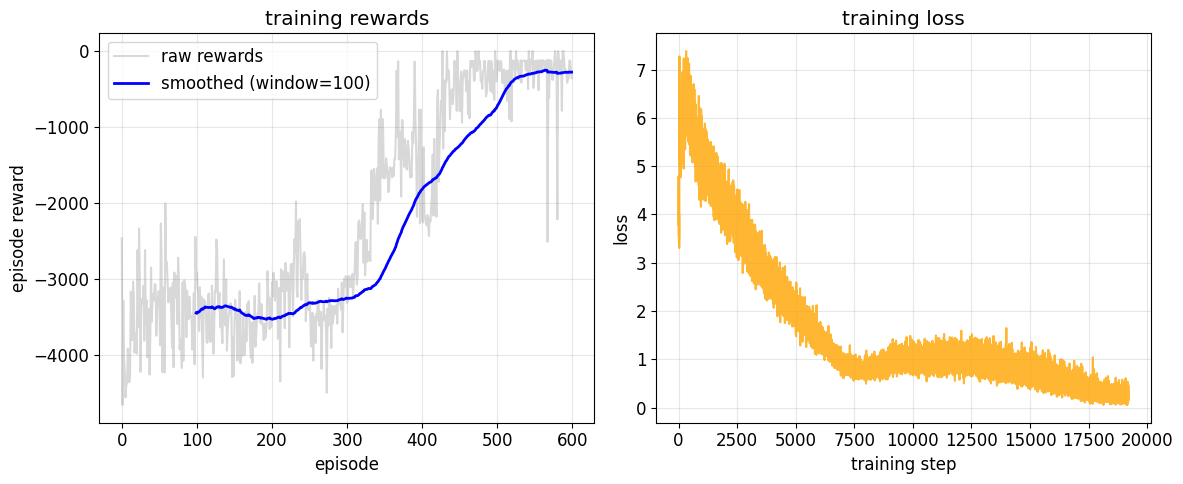

In [223]:
plot_training_progress(stats_1, losses_1)

In [224]:
q_agent.buffer.size

100000

## Evaluate (without exploration)

Please look at the behavior for a small number of episodes

In [225]:
env_eval = gym.make(env_name, render_mode="human")
if isinstance(env.action_space, spaces.Box):
    env_eval = DiscreteActionWrapper(env_eval,5)

In [226]:
def evaluate_agent(agent, env, episodes=50, max_steps=500):
    """Evaluate agent without exploration"""
    test_rewards = []
    for i in range(episodes):
        total_reward = 0
        ob, _info = env.reset()
        for t in range(max_steps):
            done = False
            a = agent.act(ob, eps=0.0)
            (ob_new, reward, done, trunc, _info) = env.step(a)
            total_reward += reward
            ob = ob_new
            if done: break
        test_rewards.append(total_reward)
    return np.array(test_rewards)

Evaluate mean and standard deviation of performance

(for the Pendulum: an average return around -30 or better should be achieved)

(for the CartPendulum it is possible to get 200)

In [227]:
# Evaluate experiment 1
env_ = env
test_1 = evaluate_agent(q_agent, env_)
print(f"Interval=1 Test: {test_1.mean():.1f} +/- {test_1.std():.1f}")

Interval=1 Test: -304.5 +/- 706.3


# Visualize

Visualization of the value function.

In [228]:
OBS_SPACE_MAP = {
    "Cart Pos": [-4.8, 4.8],
    "Pol Angle": [-0.418, 0.418],
    "Cart Vel": [-8, 8],
    "Pole Vel": [-8, 8],
    "Pendulum Cos": [-1, 1],
    "Pendulum Sin": [-1, 1],
    "Pendulum Angle Vel": [-8, 8]

}
def plot_Q_function_generic(q_function, input_dims, plot_dim1, plot_dim2, label_dim1, label_dim2):
    # retrieve observation space from labels
    plt.rcParams.update({'font.size': 12})

    xxs =np.linspace(OBS_SPACE_MAP[label_dim1][0], OBS_SPACE_MAP[label_dim1][1], 100)
    yys =np.linspace(OBS_SPACE_MAP[label_dim2][0], OBS_SPACE_MAP[label_dim2][1], 100)
    XX,YY=np.meshgrid(xxs,yys)
    dots=np.zeros((XX.size, input_dims))
    dots[:, plot_dim1] = XX.ravel()
    dots[:, plot_dim2] = YY.ravel()
    print(dots.shape)
    # values = np.asarray(test_func(dots)).reshape(XX.shape)
    values = q_function.maxQ(torch.tensor(dots,dtype=torch.float32)).detach().numpy().reshape(XX.shape)
    fig = plt.figure(figsize=[10,8])
    ax = plt.figure().add_subplot(projection='3d')
    surf = ax.plot_surface(XX, YY, values, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(elev=20, azim=45, roll=0)
    ax.set_xlabel(label_dim1)
    ax.set_ylabel(label_dim2)
    ax.set_zlabel('value')
    # plt.colorbar(cmap=cm.coolwarm)
    return fig

(10000, 3)


<Figure size 1000x800 with 0 Axes>

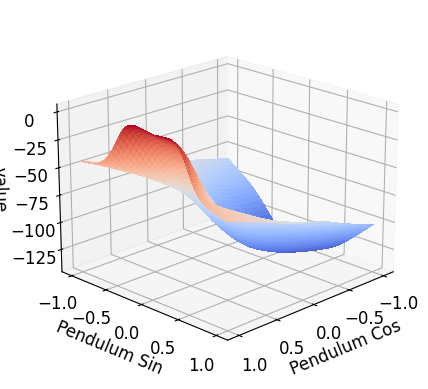

In [229]:
# Plot the current agent
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=0, plot_dim2=1, label_dim1="Pendulum Cos", label_dim2="Pendulum Sin")

(10000, 3)


<Figure size 1000x800 with 0 Axes>

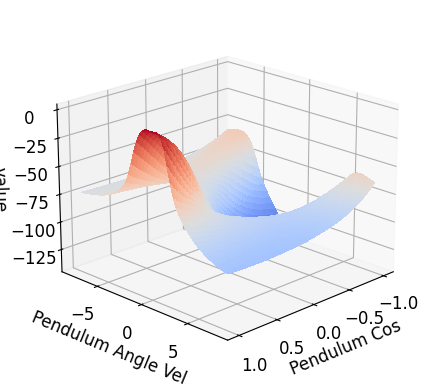

In [230]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=0, plot_dim2=2, label_dim1="Pendulum Cos", label_dim2="Pendulum Angle Vel")

(10000, 3)


<Figure size 1000x800 with 0 Axes>

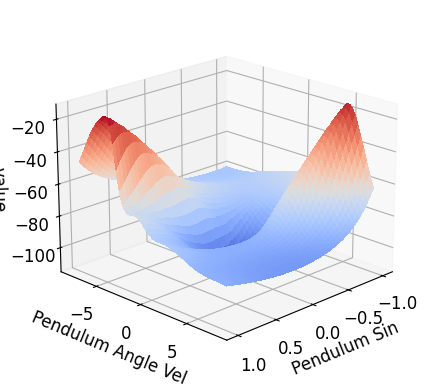

In [231]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=1, plot_dim2=2, label_dim1="Pendulum Sin", label_dim2="Pendulum Angle Vel")

Now train an agent without target network

In [232]:
# Experiment 2: No target network
q_agent = DQNAgent(o_space, ac_space, discount=0.95, eps=0.2, use_target=False)
stats_2, losses_2 = train()

1: Done after 500 steps. Reward: -3832.6072148632807
21: Done after 500 steps. Reward: -2823.5502631563963
41: Done after 500 steps. Reward: -3422.024936098615
61: Done after 500 steps. Reward: -2179.871860529954
81: Done after 500 steps. Reward: -4027.777428365523
101: Done after 500 steps. Reward: -3013.5346852161483
121: Done after 500 steps. Reward: -3708.5098690767995
141: Done after 500 steps. Reward: -3872.1157887983813
161: Done after 500 steps. Reward: -3789.6802780554967
181: Done after 500 steps. Reward: -4211.599024886534
201: Done after 500 steps. Reward: -3583.748526375216
221: Done after 500 steps. Reward: -3463.1034279248893
241: Done after 500 steps. Reward: -2707.558866228436
261: Done after 500 steps. Reward: -3038.7736160284658
281: Done after 500 steps. Reward: -2781.287896445053
301: Done after 500 steps. Reward: -3509.767800022977
321: Done after 500 steps. Reward: -2130.7479481875375
341: Done after 500 steps. Reward: -6.443101624525574
361: Done after 500 steps

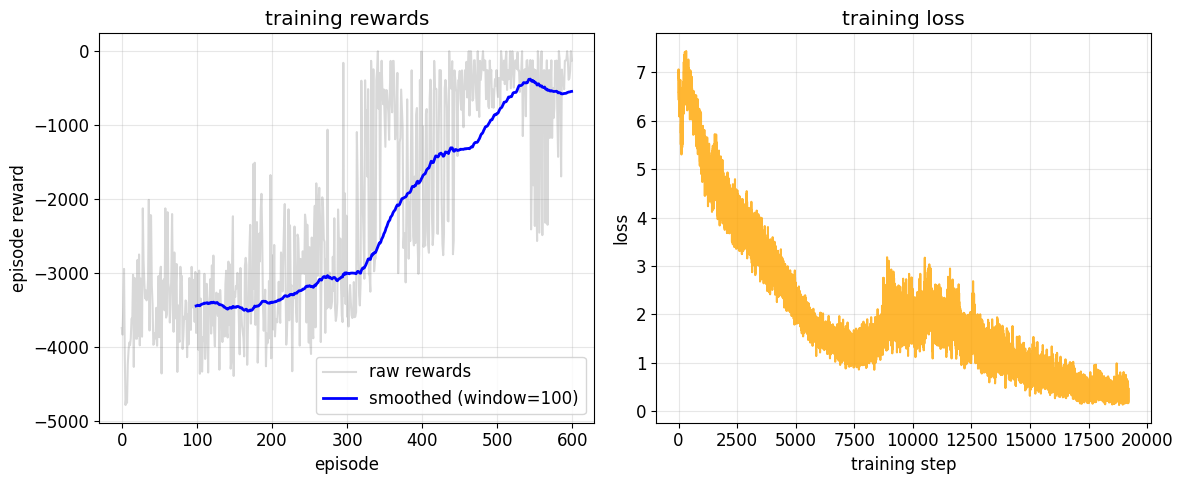

In [233]:
plot_training_progress(stats_2, losses_2)

In [234]:
# Evaluate experiment 2
env_ = env
test_2 = evaluate_agent(q_agent, env_)
print(f"No Target Test: {test_2.mean():.1f} +/- {test_2.std():.1f}")

No Target Test: -167.9 +/- 68.5


(10000, 3)


<Figure size 1000x800 with 0 Axes>

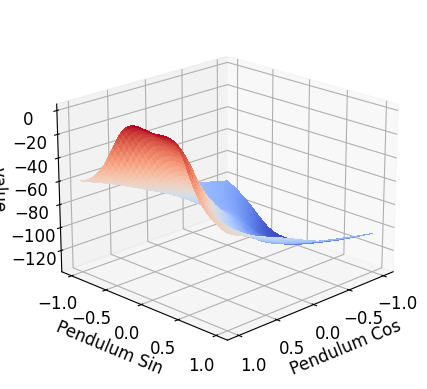

In [235]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=0, plot_dim2=1, label_dim1="Pendulum Cos", label_dim2="Pendulum Sin")

(10000, 3)


<Figure size 1000x800 with 0 Axes>

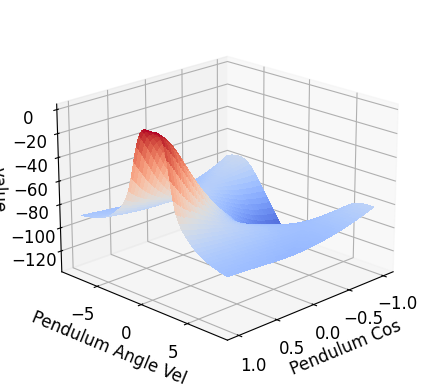

In [236]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=0, plot_dim2=2, label_dim1="Pendulum Cos", label_dim2="Pendulum Angle Vel")

(10000, 3)


<Figure size 1000x800 with 0 Axes>

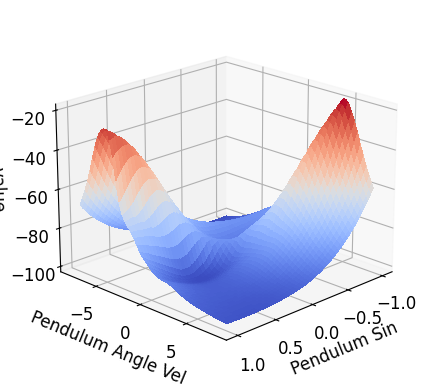

In [237]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=1, plot_dim2=2, label_dim1="Pendulum Sin", label_dim2="Pendulum Angle Vel")

Now Train agent with different target update interval

In [238]:
# Experiment 3: Target interval = 20
q_agent = DQNAgent(o_space, ac_space, discount=0.95, eps=0.2, use_target=True, target_update_interval=20)
stats_3, losses_3 = train()

1: Done after 500 steps. Reward: -4218.819549800838
21: Done after 500 steps. Reward: -4178.315850662679
41: Done after 500 steps. Reward: -3824.0791705883353
61: Done after 500 steps. Reward: -3120.751500154278
81: Done after 500 steps. Reward: -3000.6452432231663
101: Done after 500 steps. Reward: -3865.1216598544233
121: Done after 500 steps. Reward: -2248.3032423007794
141: Done after 500 steps. Reward: -3402.114811977844
161: Done after 500 steps. Reward: -3672.3456853720936
181: Done after 500 steps. Reward: -3340.3539173451904
201: Done after 500 steps. Reward: -3323.87548604915
221: Done after 500 steps. Reward: -3379.5753383068386
241: Done after 500 steps. Reward: -1995.3851923686427
261: Done after 500 steps. Reward: -2245.6685208771355
281: Done after 500 steps. Reward: -2306.0915795725687
301: Done after 500 steps. Reward: -2195.1598356027516
321: Done after 500 steps. Reward: -1778.025118476325
341: Done after 500 steps. Reward: -1624.350383032334
361: Done after 500 step

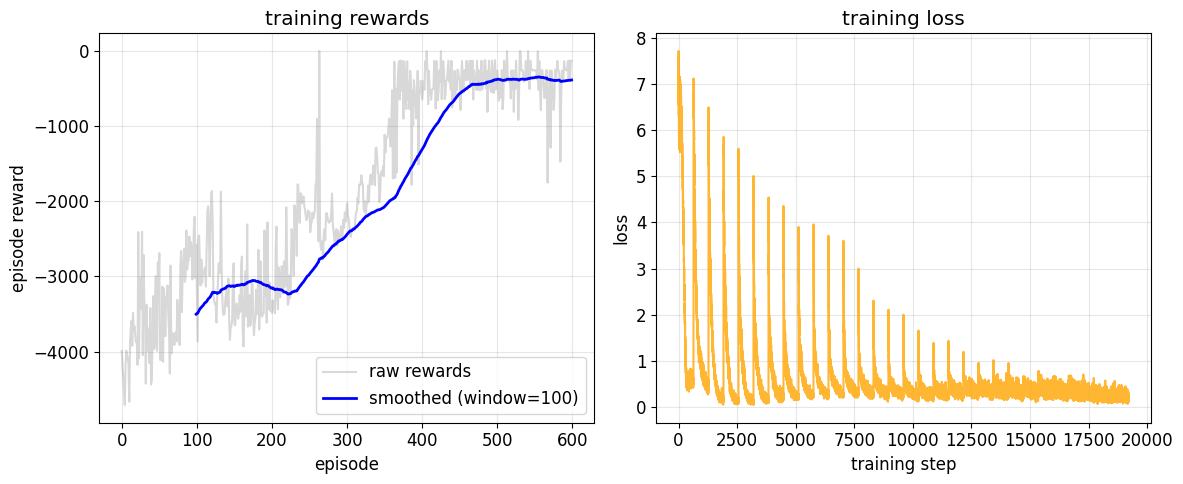

In [239]:
plot_training_progress(stats_3, losses_3)

In [240]:
# Evaluate experiment 3
env_ = env
test_3 = evaluate_agent(q_agent, env_)
print(f"Interval=20 Test: {test_3.mean():.1f} +/- {test_3.std():.1f}")

Interval=20 Test: -235.1 +/- 509.1


(10000, 3)


<Figure size 1000x800 with 0 Axes>

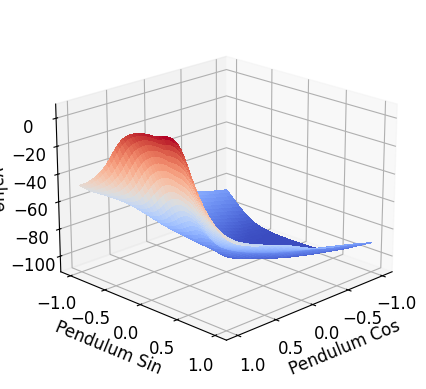

In [241]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=0, plot_dim2=1, label_dim1="Pendulum Cos", label_dim2="Pendulum Sin")

(10000, 3)


<Figure size 1000x800 with 0 Axes>

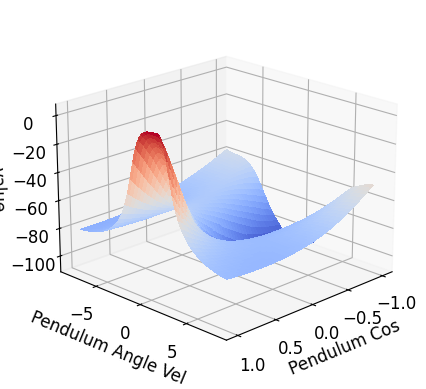

In [242]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=0, plot_dim2=2, label_dim1="Pendulum Cos", label_dim2="Pendulum Angle Vel")

(10000, 3)


<Figure size 1000x800 with 0 Axes>

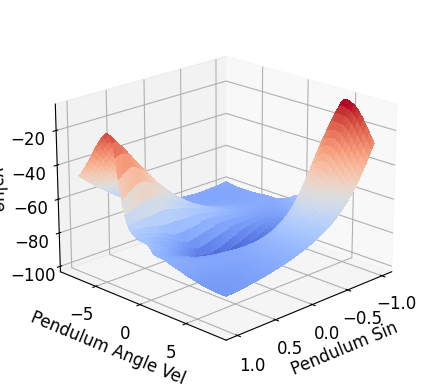

In [243]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=1, plot_dim2=2, label_dim1="Pendulum Sin", label_dim2="Pendulum Angle Vel")

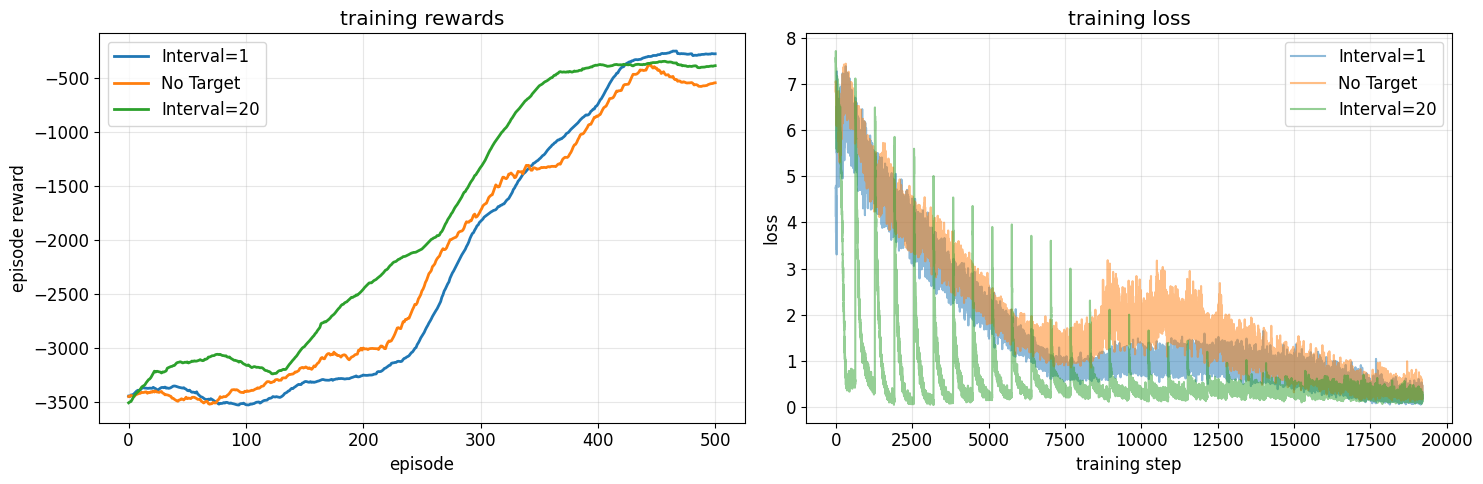

In [244]:
# Comparison plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
window = 100
plt.plot(running_mean(stats_1[:, 1], window), label='Interval=1', linewidth=2)
plt.plot(running_mean(stats_2[:, 1], window), label='No Target', linewidth=2)
plt.plot(running_mean(stats_3[:, 1], window), label='Interval=20', linewidth=2)
plt.xlabel('episode')
plt.ylabel('episode reward')
plt.title('training rewards')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(losses_1, alpha=0.5, label='Interval=1')
plt.plot(losses_2, alpha=0.5, label='No Target')
plt.plot(losses_3, alpha=0.5, label='Interval=20')
plt.xlabel('training step')
plt.ylabel('loss')
plt.title('training loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("pendulum_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

In [245]:
# Summary
print("Pendulum Mean Reward Summary:")
print(f"Interval=1:  Train={stats_1[-1,1]:.1f}, Test={test_1.mean():.1f}+/-{test_1.std():.1f}")
print(f"No Target:   Train={stats_2[-1,1]:.1f}, Test={test_2.mean():.1f}+/-{test_2.std():.1f}")
print(f"Interval=20: Train={stats_3[-1,1]:.1f}, Test={test_3.mean():.1f}+/-{test_3.std():.1f}")

Pendulum Mean Reward Summary:
Interval=1:  Train=-357.3, Test=-304.5+/-706.3
No Target:   Train=-130.7, Test=-167.9+/-68.5
Interval=20: Train=-133.9, Test=-235.1+/-509.1


## Pendulum Env

Observation space:

0 angle

1 angular velocity

Do that for the pendulum function. Does it look like you expect?

Answer: It’s not expected as the visualization is misleading because the values appear flipped, showing the highest Q near the down position instead of the upright one given the cosine value, i.e. high reward at cosine 1 which is down. Other values appear correct with the flipped cosine, such as that with a cosine of 1 (the flipped upright) we have the highest reward with 0 velocity.

## Cartpole Env

Observation space:
 
0       Cart Position             -4.8                    4.8

1       Cart Velocity             -Inf                    Inf

2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)

3       Pole Angular Velocity     -Inf                    Inf

Try to adapt the plotting function that it also works in higher input spaces where all other inputs are 0

In [246]:
# CartPole
env_name = "CartPole-v1"
env = gym.make(env_name)
ac_space = env.action_space
o_space = env.observation_space
print(ac_space)
print(o_space)

Discrete(2)
Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


In [247]:
# Experiment 1: interval=1
q_agent = DQNAgent(o_space, ac_space, discount=0.95, eps=0.2, use_target=True, target_update_interval=1)
stats_c1, losses_c1 = train()

1: Done after 25 steps. Reward: 25.0
21: Done after 10 steps. Reward: 10.0
41: Done after 16 steps. Reward: 16.0
61: Done after 16 steps. Reward: 16.0
81: Done after 219 steps. Reward: 219.0
101: Done after 46 steps. Reward: 46.0
121: Done after 27 steps. Reward: 27.0
141: Done after 75 steps. Reward: 75.0
161: Done after 220 steps. Reward: 220.0
181: Done after 275 steps. Reward: 275.0
201: Done after 268 steps. Reward: 268.0
221: Done after 236 steps. Reward: 236.0
241: Done after 195 steps. Reward: 195.0
261: Done after 222 steps. Reward: 222.0
281: Done after 178 steps. Reward: 178.0
301: Done after 178 steps. Reward: 178.0
321: Done after 124 steps. Reward: 124.0
341: Done after 13 steps. Reward: 13.0
361: Done after 13 steps. Reward: 13.0
381: Done after 10 steps. Reward: 10.0
401: Done after 11 steps. Reward: 11.0
421: Done after 162 steps. Reward: 162.0
441: Done after 17 steps. Reward: 17.0
461: Done after 154 steps. Reward: 154.0
481: Done after 75 steps. Reward: 75.0
501: Do

In [248]:
env_ = env
test_c1 = evaluate_agent(q_agent, env_)
print(f"CartPole Interval=1: {test_c1.mean():.1f}+/-{test_c1.std():.1f}")

CartPole Interval=1: 138.4+/-3.9


In [249]:
# Experiment 2: no target
q_agent = DQNAgent(o_space, ac_space, discount=0.95, eps=0.2, use_target=False)
stats_c2, losses_c2 = train()

1: Done after 12 steps. Reward: 12.0
21: Done after 9 steps. Reward: 9.0
41: Done after 12 steps. Reward: 12.0
61: Done after 11 steps. Reward: 11.0
81: Done after 21 steps. Reward: 21.0
101: Done after 27 steps. Reward: 27.0
121: Done after 22 steps. Reward: 22.0
141: Done after 16 steps. Reward: 16.0
161: Done after 29 steps. Reward: 29.0
181: Done after 228 steps. Reward: 228.0
201: Done after 122 steps. Reward: 122.0
221: Done after 120 steps. Reward: 120.0
241: Done after 196 steps. Reward: 196.0
261: Done after 156 steps. Reward: 156.0
281: Done after 160 steps. Reward: 160.0
301: Done after 152 steps. Reward: 152.0
321: Done after 141 steps. Reward: 141.0
341: Done after 127 steps. Reward: 127.0
361: Done after 193 steps. Reward: 193.0
381: Done after 142 steps. Reward: 142.0
401: Done after 66 steps. Reward: 66.0
421: Done after 141 steps. Reward: 141.0
441: Done after 115 steps. Reward: 115.0
461: Done after 121 steps. Reward: 121.0
481: Done after 196 steps. Reward: 196.0
501

In [250]:
env_ = env
test_c2 = evaluate_agent(q_agent, env_)
print(f"CartPole No Target: {test_c2.mean():.1f}+/-{test_c2.std():.1f}")

CartPole No Target: 144.9+/-13.7


In [251]:
# Experiment 3: interval=20
q_agent = DQNAgent(o_space, ac_space, discount=0.95, eps=0.2, use_target=True, target_update_interval=20)
stats_c3, losses_c3 = train()

1: Done after 12 steps. Reward: 12.0
21: Done after 11 steps. Reward: 11.0
41: Done after 18 steps. Reward: 18.0
61: Done after 19 steps. Reward: 19.0
81: Done after 23 steps. Reward: 23.0
101: Done after 152 steps. Reward: 152.0
121: Done after 129 steps. Reward: 129.0
141: Done after 107 steps. Reward: 107.0
161: Done after 129 steps. Reward: 129.0
181: Done after 136 steps. Reward: 136.0
201: Done after 148 steps. Reward: 148.0
221: Done after 122 steps. Reward: 122.0
241: Done after 134 steps. Reward: 134.0
261: Done after 120 steps. Reward: 120.0
281: Done after 144 steps. Reward: 144.0
301: Done after 158 steps. Reward: 158.0
321: Done after 159 steps. Reward: 159.0
341: Done after 122 steps. Reward: 122.0
361: Done after 137 steps. Reward: 137.0
381: Done after 143 steps. Reward: 143.0
401: Done after 125 steps. Reward: 125.0
421: Done after 135 steps. Reward: 135.0
441: Done after 149 steps. Reward: 149.0
461: Done after 134 steps. Reward: 134.0
481: Done after 156 steps. Rewar

In [252]:
env_ = env
test_c3 = evaluate_agent(q_agent, env_)
print(f"CartPole Interval=20: {test_c3.mean():.1f}+/-{test_c3.std():.1f}")

CartPole Interval=20: 181.9+/-6.9


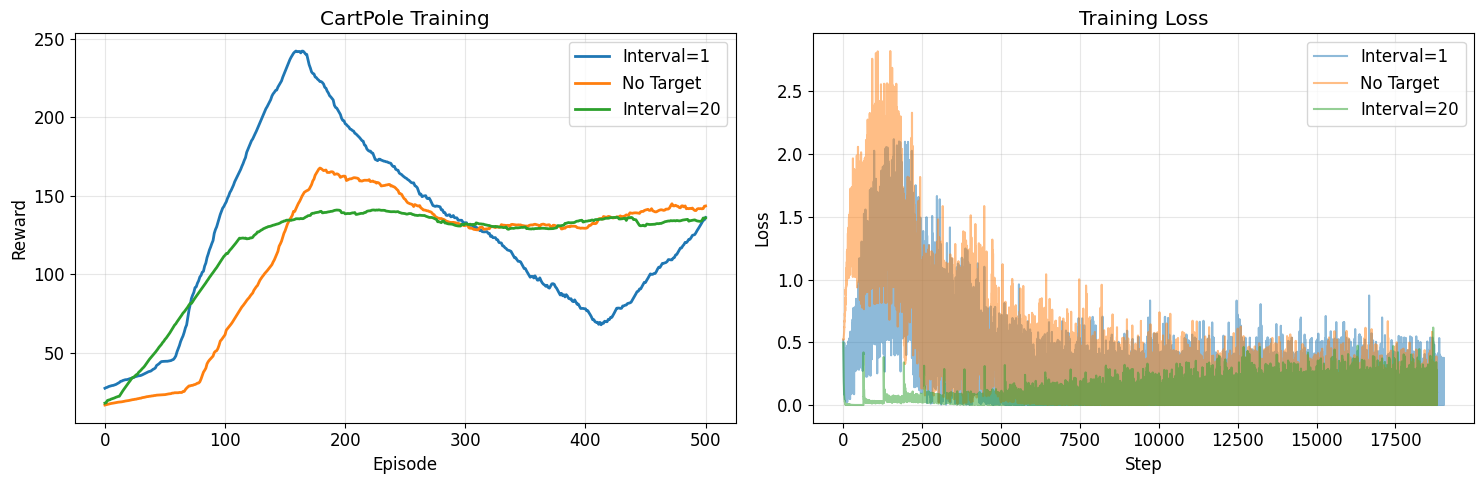

In [253]:
# CartPole comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
window = 100
plt.plot(running_mean(stats_c1[:, 1], window), label="Interval=1", linewidth=2)
plt.plot(running_mean(stats_c2[:, 1], window), label="No Target", linewidth=2)
plt.plot(running_mean(stats_c3[:, 1], window), label="Interval=20", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("CartPole Training")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(losses_c1, alpha=0.5, label="Interval=1")
plt.plot(losses_c2, alpha=0.5, label="No Target")
plt.plot(losses_c3, alpha=0.5, label="Interval=20")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("cartpole_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

In [259]:
print("Cartpole Mean Reward Summary:")
print(f"Interval=1:  Train={stats_c1[-1,1]:.1f}, Test={test_c1.mean():.1f}+/-{test_c1.std():.1f}")
print(f"No Target:   Train={stats_c2[-1,1]:.1f}, Test={test_c2.mean():.1f}+/-{test_c2.std():.1f}")
print(f"Interval=20: Train={stats_c3[-1,1]:.1f}, Test={test_c3.mean():.1f}+/-{test_c3.std():.1f}")

Cartpole Mean Reward Summary:
Interval=1:  Train=159.0, Test=138.4+/-3.9
No Target:   Train=149.0, Test=144.9+/-13.7
Interval=20: Train=178.0, Test=181.9+/-6.9


(10000, 4)


<Figure size 1000x800 with 0 Axes>

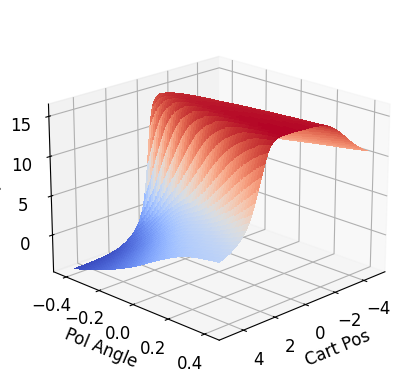

In [254]:
# CartPole Q-function
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=0, plot_dim2=2,
                       label_dim1="Cart Pos", label_dim2="Pol Angle")

(10000, 4)


<Figure size 1000x800 with 0 Axes>

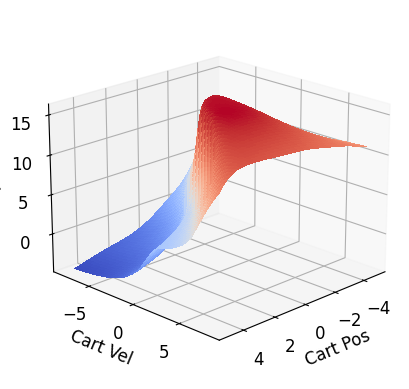

In [255]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=0, plot_dim2=1, 
                       label_dim1="Cart Pos", label_dim2="Cart Vel")

(10000, 4)


<Figure size 1000x800 with 0 Axes>

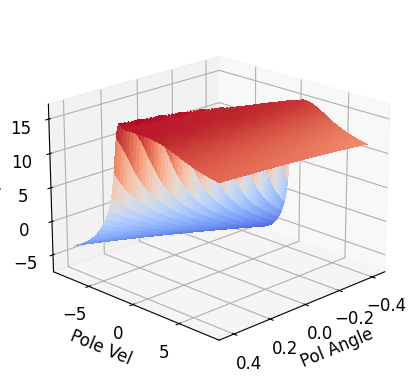

In [256]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=2, plot_dim2=3, 
                       label_dim1="Pol Angle", label_dim2="Pole Vel")

In [257]:
%matplotlib notebook

In [258]:
# env_name = 'Acrobot-v1'
# env_name = 'MountainCar-v0'
# env_name = 'LunarLander-v2'